In [21]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [22]:
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision.datasets import ImageFolder
from torchvision import transforms
from sklearn.model_selection import train_test_split


class MuseumDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Путь к CSV файлу со списком изображений.
            root_dir (string): Директория с изображениями.
            transform (callable, optional): Преобразование, применяемое к изображению.
        """
        self.annotations = pd.read_csv(csv_file, delimiter=';')
        self.root_dir = root_dir
        self.transform = transform
        
        self.images = ImageFolder(root=root_dir, transform=transform)
        self.image_paths = {os.path.basename(path): path for path, _ in self.images.imgs}


    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        image_name = self.annotations.iloc[idx, 4]
        image = Image.open(self.image_paths.get(image_name)).convert("RGB")

        if self.transform is not None:
            image = self.transform(image)
            

        group = self.annotations.iloc[idx, 3]
        desc = self.annotations.iloc[idx, 2]
        name = self.annotations.iloc[idx, 1]
        

        sample = {
            'image': image,
            'group': group,
            'img_name': image_name,
            'description': description
        }
        
        return sample

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [25]:
dataset = MuseumDataset(csv_file='/kaggle/input/mincult-museum-dataset/train_dataset_mincult-train/train.csv', root_dir='/kaggle/input/mincult-museum-dataset/train_dataset_mincult-train/train', transform=transform)

indices = list(range(len(dataset)))
train_indices, test_indices = train_test_split(indices, test_size=0.8, random_state=42)

train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
test_sampler = torch.utils.data.SubsetRandomSampler(test_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=32, sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=32, sampler=test_sampler)

In [26]:
import torch
import torchvision.models as models

device = 'cuda'

encoder = models.inception_v3(pretrained=True, aux_logits=True).to(device)
encoder.eval()


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [15]:
from tqdm import tqdm
import torch

embeddings = []
covariances = []
covariance_traces = []
image_names = []
groups = []


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

encoder.to(device)

all_embeddings = torch.empty(0).to(device)

for batch_num, batch in tqdm(enumerate(train_loader), total=len(train_loader)):
    batch_images = batch['image'].to(device)
    batch_embeddings = encoder(batch_images).detach()
    all_embeddings = torch.cat([all_embeddings, batch_embeddings], dim=0)
    image_names.extend(batch['img_name'])
    groups.extend(batch['group'])
    

embeddings = all_embeddings.cpu().numpy()

covariance = np.cov(embeddings, rowvar=False)
covariance_trace = np.trace(covariance)

covariances.append(covariance)
covariance_traces.append(covariance_trace)

  0%|          | 0/128 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 128/128 [03:29<00:00,  1.64s/it]


In [16]:
groups

['Техника',
 'Скульптура',
 'Минералогия',
 'Фото, негативы',
 'Графика',
 'Живопись',
 'Техника',
 'Графика',
 'Минералогия',
 'Оружие',
 'Редкие книги',
 'Нумизматика',
 'Печатная продукция',
 'Минералогия',
 'Фото, негативы',
 'Живопись',
 'Редкие книги',
 'Графика',
 'Документы',
 'Документы',
 'Живопись',
 'Минералогия',
 'Оружие',
 'Нумизматика',
 'Техника',
 'Редкие книги',
 'Минералогия',
 'Оружие',
 'Прочие',
 'Нумизматика',
 'Скульптура',
 'Прочие',
 'Минералогия',
 'Естественнонауч.коллекция',
 'Естественнонауч.коллекция',
 'Нумизматика',
 'Оружие',
 'Графика',
 'Графика',
 'Минералогия',
 'Техника',
 'Естественнонауч.коллекция',
 'Скульптура',
 'ДПИ',
 'Минералогия',
 'Техника',
 'ДПИ',
 'Минералогия',
 'Фото, негативы',
 'Документы',
 'Техника',
 'Фото, негативы',
 'Археология',
 'Оружие',
 'Археология',
 'Печатная продукция',
 'Печатная продукция',
 'Прочие',
 'Документы',
 'Археология',
 'Скульптура',
 'Техника',
 'Естественнонауч.коллекция',
 'Графика',
 'Нумизматика',


In [17]:
import h5py
file_path = "embedding_data3v.h5"
with h5py.File(file_path, "w") as f:
    f.create_dataset("embeddings", data=embeddings)
    f.create_dataset("covariance", data=covariance)
    f.create_dataset("covariance_trace", data=covariance_trace)
    f.create_dataset("img_name", data=image_names)
    f.create_dataset("groups", data=groups)
    

In [83]:
import h5py
from torchvision.datasets import ImageFolder
from torchvision import transforms

file_path = "/kaggle/input/mincult-museum-dataset/embedding_data3v.h5"
with h5py.File(file_path, "r") as f:
    embeddings = f["embeddings"][:]
    covariance = f["covariance"][:]
    covariance_trace = f["covariance_trace"][()]
    img_names = f["img_name"][:]
    groups = f["groups"][:]

images = ImageFolder(root='/kaggle/input/mincult-museum-dataset/train_dataset_mincult-train/train', transform=transform)
image_paths = {os.path.basename(path): path for path, _ in images.imgs}

In [84]:
import random
image_path = list(dataset.image_paths.values())[random.randint(13000, 15000)]
image = Image.open(image_path)
image_tensor = transform(image).unsqueeze(0).to(device)

query_embedding = encoder(image_tensor).detach().cpu().numpy().squeeze()

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [87]:
from sklearn.neighbors import NearestNeighbors
covariance_embeddings = np.hstack((embeddings, np.tile(covariance_trace, (len(embeddings), 1))))

knn_with_trace = NearestNeighbors(n_neighbors=10, metric='cosine')
knn_with_trace.fit(covariance_embeddings)

array([[ 0.54343873, -0.64491135,  1.3257871 , ...,  0.1770795 ,
         0.10601503, -0.6889395 ],
       [-0.63539   ,  0.22274986, -0.3481677 , ...,  2.5228865 ,
        -0.33959883,  0.7483905 ],
       [-0.6313511 ,  0.08624753, -0.47764242, ..., -0.50632906,
         0.44747147, -1.3504215 ],
       ...,
       [-0.93859696, -0.46720856, -0.68218297, ..., -0.95179397,
         0.81610024,  2.4153042 ],
       [ 0.09702109,  0.8206687 ,  0.13726582, ..., -0.9646137 ,
        -0.10568462,  1.1085318 ],
       [-0.14249082, -1.0127437 , -0.6033958 , ...,  0.0295788 ,
         0.06396829,  3.123506  ]], dtype=float32)

In [61]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

query_embedding_vectorized = query_embedding.flatten()
query_covariance = np.cov(query_embedding_vectorized)
query_embedding_with_covariance = np.hstack((query_embedding, query_covariance.flatten()))

distances, indices = knn_with_trace.kneighbors([query_embedding_with_covariance])

for distance, index in zip(distances[0], indices[0]):
    print(f"Distance: {distance}, Index: {index}")

indices = indices.tolist()[0]

Distance: 0.9455967759768686, Index: 833
Distance: 0.945847796102974, Index: 3463
Distance: 0.9467930248177616, Index: 642
Distance: 0.946822362649679, Index: 2152
Distance: 0.9468430992906173, Index: 3721
Distance: 0.9472301450661407, Index: 3960
Distance: 0.947553072864667, Index: 3521
Distance: 0.9479407520260178, Index: 48
Distance: 0.9480344516368414, Index: 3989
Distance: 0.9482834164192245, Index: 2129


In [74]:
import joblib

joblib.dump(knn_with_trace, 'image_searcher.pkl')

['image_searcher.pkl']

In [76]:
modelscorev2 = joblib.load('image_searcher.pkl' , mmap_mode ='r')
prediction = modelscorev2.kneighbors([query_embedding_with_covariance])
prediction

(array([[0.95787879, 0.95982612, 0.96025329, 0.96050607, 0.96076367,
         0.9619799 , 0.96211394, 0.96224281, 0.96228347, 0.96238841]]),
 array([[3006, 1490, 3037, 3182,  998,  969,   62,  463, 4054, 4015]]))

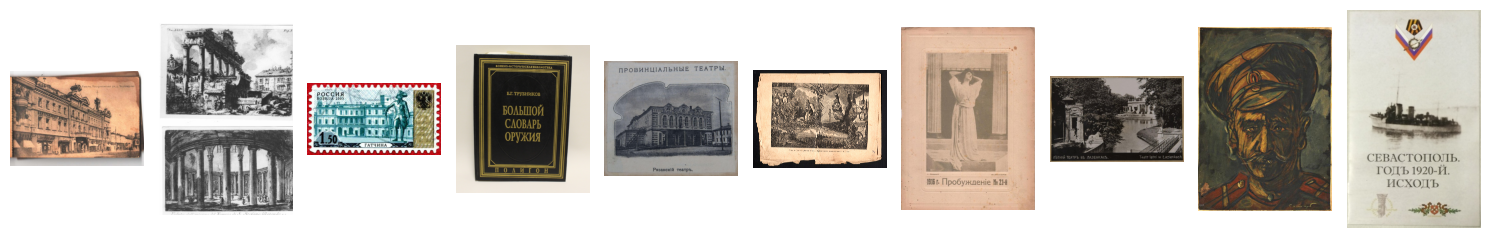

In [32]:
import matplotlib.pyplot as plt
from PIL import Image


fig, axes = plt.subplots(ncols=10, figsize=(15, 8))

for id in range(len(indices)):
    image_path = image_paths.get(img_names[indices[id]].decode('utf-8'))

    axes[id].imshow(Image.open(image_path))
    axes[id].axis('off')


plt.tight_layout() 
plt.show()

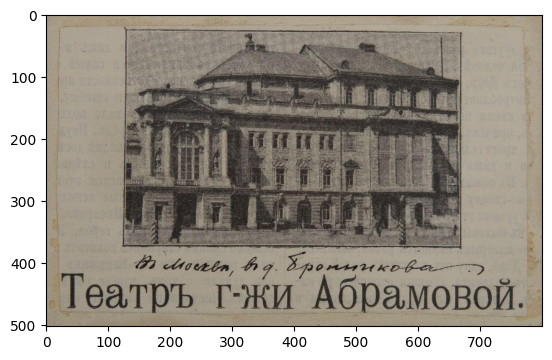

In [33]:
plt.imshow(image)

In [37]:
groups_text = [group.decode('utf-8') for group in groups]

In [91]:
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score

# Ваш код для загрузки данных и предобработки

X = embeddings
y = groups_text

label_encoder = LabelEncoder()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Инициализация и обучение модели XGBoost
xgb_model = XGBClassifier(objective='multi:softmax', num_class=len(label_encoder.classes_))
xgb_model.fit(X_train, y_train_encoded)

# Инициализация и обучение модели KNN
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train_encoded)

# Предсказания моделей
xgb_predictions = xgb_model.predict(X_test)
knn_predictions = knn_model.predict(X_test)

# Оценка точности
xgb_accuracy = accuracy_score(y_test_encoded, xgb_predictions)
knn_accuracy = accuracy_score(y_test_encoded, knn_predictions)

# Вычисление взвешенной F-меры
xgb_f1_score = f1_score(y_test_encoded, xgb_predictions, average='weighted')
knn_f1_score = f1_score(y_test_encoded, knn_predictions, average='weighted')

print("XGBoost Accuracy:", xgb_accuracy)
print("XGBoost Weighted F1-score:", xgb_f1_score)
print("KNN Accuracy:", knn_accuracy)
print("KNN Weighted F1-score:", knn_f1_score)

XGBoost Accuracy: 0.6523341523341524
XGBoost Weighted F1-score: 0.6466472821255982
KNN Accuracy: 0.6228501228501229
KNN Weighted F1-score: 0.6107461370577315


In [93]:
from sklearn.ensemble import VotingClassifier

# Создаем ансамбль с помощью метода голосования
ensemble_model = VotingClassifier(estimators=[
    ('xgb', xgb_model),
    ('knn', knn_model)
], voting='soft')  # 'soft' использует вероятности предсказаний для голосования

# Обучаем ансамбль
ensemble_model.fit(X_train, y_train_encoded)

# Предсказываем классы для тестовой выборки
ensemble_predictions = ensemble_model.predict(X_test)

# Вычисляем точность ансамбля
ensemble_accuracy = accuracy_score(y_test_encoded, ensemble_predictions)

print("Ensemble Accuracy:", ensemble_accuracy)
from sklearn.metrics import f1_score

ensemble_f1_score = f1_score(y_test_encoded, ensemble_predictions, average='weighted')

print("Ensemble Weighted F1-score:", ensemble_f1_score)


Ensemble Accuracy: 0.6683046683046683
Ensemble Weighted F1-score: 0.659866947152312


In [69]:
len(label_encoder.classes_)

15

In [94]:
import joblib

joblib.dump(ensemble_model, 'ensemble_image_classifierv3.pkl')

['ensemble_image_classifierv3.pkl']

In [62]:
query_embedding_with_covariance = query_embedding_with_covariance.reshape(-1, 1).T

In [65]:
ensemble_predictions = ensemble_model.predict(query_embedding_with_covariance)
label_encoder.classes_[ensemble_predictions]

array(['Фото, негативы'], dtype='<U25')

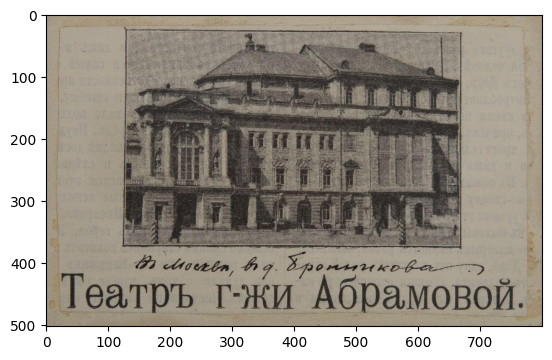

In [66]:
plt.imshow(image)

In [72]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Ваш код для загрузки данных и предобработки

X = embeddings
y = groups_text

label_encoder = LabelEncoder()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Многоклассовая классификация с CatBoost с использованием F1 в качестве функции потерь и GPU
catboost_model = CatBoostClassifier(loss_function='MultiClassOneVsAll', custom_metric=['F1'], verbose=True, task_type='GPU')
catboost_model.fit(X_train, y_train_encoded, eval_set=(X_test, y_test_encoded))

# Многоклассовая классификация с логистической регрессией
logreg_model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
logreg_model.fit(X_train, y_train_encoded)

# Предсказания моделей
catboost_predictions = catboost_model.predict(X_test)
logreg_predictions = logreg_model.predict(X_test)

# Оценка точности
catboost_accuracy = accuracy_score(y_test_encoded, catboost_predictions)
logreg_accuracy = accuracy_score(y_test_encoded, logreg_predictions)

# Вычисление взвешенной F-меры
catboost_f1_score = f1_score(y_test_encoded, catboost_predictions, average='weighted')
logreg_f1_score = f1_score(y_test_encoded, logreg_predictions, average='weighted')

print("CatBoost Accuracy:", catboost_accuracy)
print("CatBoost Weighted F1-score:", catboost_f1_score)
print("Logistic Regression Accuracy:", logreg_accuracy)
print("Logistic Regression Weighted F1-score:", logreg_f1_score)


0:	learn: 0.6716671	test: 0.6717736	best: 0.6717736 (0)	total: 123ms	remaining: 2m 2s
1:	learn: 0.6517090	test: 0.6522807	best: 0.6522807 (1)	total: 240ms	remaining: 1m 59s
2:	learn: 0.6327342	test: 0.6333880	best: 0.6333880 (2)	total: 322ms	remaining: 1m 47s
3:	learn: 0.6146228	test: 0.6157979	best: 0.6157979 (3)	total: 406ms	remaining: 1m 41s
4:	learn: 0.5976343	test: 0.5992456	best: 0.5992456 (4)	total: 484ms	remaining: 1m 36s
5:	learn: 0.5813090	test: 0.5832781	best: 0.5832781 (5)	total: 553ms	remaining: 1m 31s
6:	learn: 0.5654631	test: 0.5676870	best: 0.5676870 (6)	total: 622ms	remaining: 1m 28s
7:	learn: 0.5511527	test: 0.5534458	best: 0.5534458 (7)	total: 697ms	remaining: 1m 26s
8:	learn: 0.5368351	test: 0.5392347	best: 0.5392347 (8)	total: 764ms	remaining: 1m 24s
9:	learn: 0.5234425	test: 0.5260826	best: 0.5260826 (9)	total: 839ms	remaining: 1m 23s
10:	learn: 0.5107441	test: 0.5135195	best: 0.5135195 (10)	total: 912ms	remaining: 1m 22s
11:	learn: 0.4982282	test: 0.5011553	best: